# 데이터 이해 및 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = './DATA/' #데이터경로 설정

In [2]:
train_data = pd.read_table(DATA_PATH + 'ratings_train.txt')
test_data = pd.read_table(DATA_PATH + 'ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
#긍정 1, 부정 0
print('긍정 리뷰 갯수: {}'.format(train_data['label'].value_counts()[1]))
print('부정 리뷰 갯수: {}'.format(train_data['label'].value_counts()[0]))

긍정 리뷰 갯수: 74827
부정 리뷰 갯수: 75173


## 데이터 전처리

In [5]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [6]:
train_data['document'][:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

In [7]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
train_data['document'][:5]

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [8]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True) # 리뷰에 비어있으면 NULL 값으로 대체
# NULL값이 존재하는 행이 있는지 확인
print(train_data.isnull().sum())

id             0
document    1260
label          0
dtype: int64


In [9]:
# NULL값이 존재하는 5개의 행 출력
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [10]:
train_data = train_data.dropna(how = 'any')
print('전처리 후 train 데이터의 개수: ', len(train_data))

전처리 후 train 데이터의 개수:  148740


In [11]:
# train 데이터와 마찬가지로 test 데이터 전처리
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # empty은 NULL 값으로 변경
test_data = test_data.dropna(how='any') # NULL 값 제거
print('전처리 후 test 데이터의 개수 :',len(test_data))

전처리 후 test 데이터의 개수 : 49575


In [12]:
# 불용어 정의
stopwords = ['은','는','이','가','하','아','것','들','의','있','되',
             '수','보','주','등','한', '좀', '잘', '걍', '과', '도',
             '을', '를', '으로', '자', '에', '와', '하다']
okt = Okt()

In [13]:
# 형태소 분석기 okt를 통해 토근화를 하면서 불용어 제거 후 X_train에 저장
X_train = []
for sentence in train_data['document']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

In [14]:
print(X_train[:4])

[['더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]


In [15]:
# train 데이터와 마찬가지로 test 데이터 토큰화 및 불용어 제거
X_test = []
for sentence in test_data['document']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

In [16]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 train데이터에 정수 인코딩 수행, 먼저 train데이터에 대해 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

In [ ]:
type(tokenizer.word_index)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [21]:
# 케라스 토크나이저의 인자로 넘긴 후 텍스트 시퀀스를 정수 시퀀스로 변환 (0 ~ 19416)
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
type(X_train)

list

In [23]:
# 변환 됐는지 확인
print(X_train[:4])

[[451, 15, 255, 652], [911, 453, 39, 592, 1, 209, 1447, 23, 957, 668, 18], [381, 2444, 2311, 5668, 2, 216, 8], [6492, 100, 8125, 214, 53, 3, 24, 3609]]


In [24]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [25]:
#빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

148474
148474


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.338106335115912


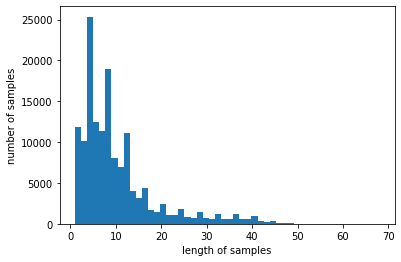

In [26]:
# 서로다른 길이의 리뷰들의 길이를 동일하게 맞춰주는 패딩 작업 진행
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [28]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.96026240284495


In [29]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [31]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  911,  453,   39,  592,    1,
        209, 1447,   23,  957,  668,   18], dtype=int32)

In [30]:
# 다 대 일 구조의 LSTM 모델 사용, 이진 분류 문제 수행
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/5


UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/StatefulPartitionedCall]]
	 [[gradient_tape/sequential/embedding/embedding_lookup/Reshape/_34]] [Op:__inference_train_function_3294]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [48]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    print(new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    print(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    print(new_sentence)
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    print('encoded = ', encoded)
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    print('pad_new = ', pad_new)
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [49]:
sentiment_predict(input('감성 분석할 문장을 입력하시오: '))

감성 분석할 문장을 입력하시오: 과연 내 인생영화
92.39% 확률로 긍정 리뷰입니다.

